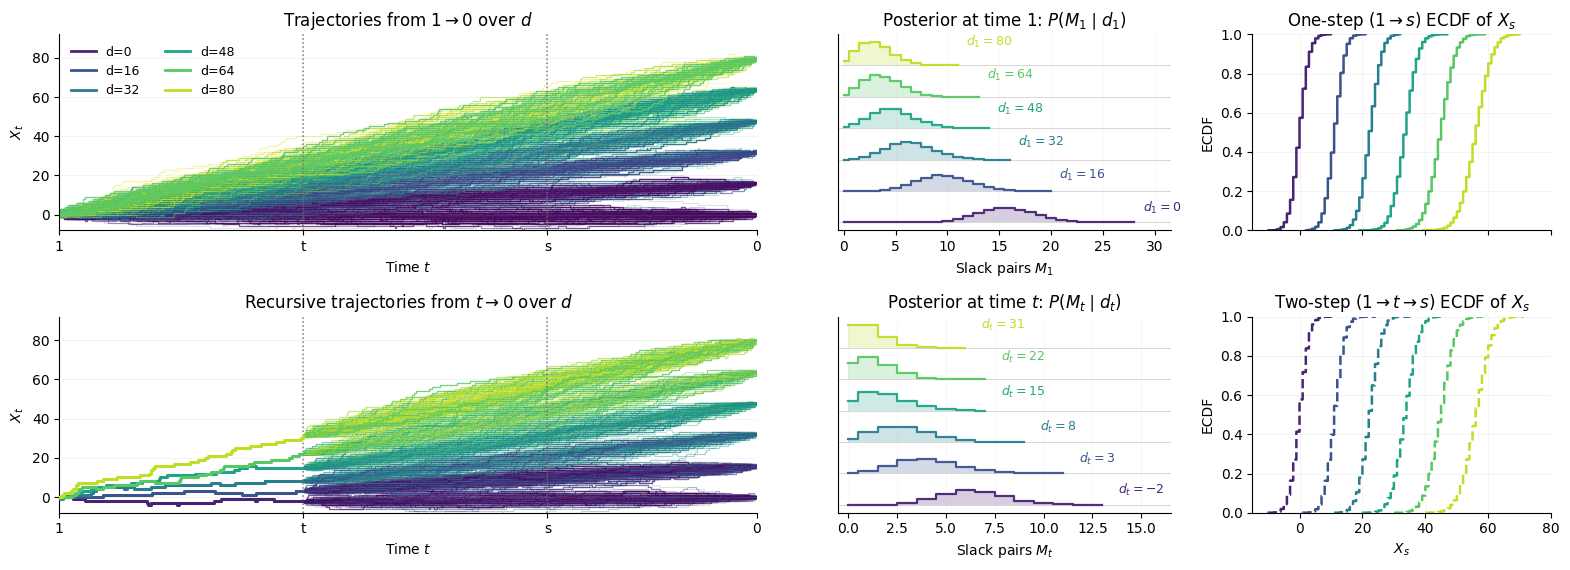

In [52]:
# === Poisson BD bridge: integrated demo figure ================================
# Panels:
# A(top)    paths 1->0 for several d (no shared backbone), color by total M1
# A(bottom) single trunk to t (black), then many branches t->0 (same x1);
#           branch tones/alpha/width keyed to *total* M1, so they match A(top)
# B(top)    ridgeline posteriors P(M1 | d1)
# B(bottom) ridgeline posteriors P(M_t | d_t)
# C(top)    ECDF one-step 1->s
# C(bottom) ECDF two-step 1->t->s
# ============================================================================

from bridges.numpy.sampling.bessel import sample_bessel_devroye
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy.random import default_rng

rng = default_rng(14)

# -------------------- knobs ---------------------------------------------------
x0 = 0
alpha_total = 16.0
beta_total  = 16.0
d_list      = [0, 16, 32, 48, 64, 80]

t_mid, s_end = 0.35, 0.70            # homogeneous case: W(t)=t
n_traj_per_d   = 100                 # A(top)
n_branches     = 100                 # A(bottom)
n_m_samples    = 30_000              # PMF for M1
n_m_samples_t  = 30_000              # PMF for M_t
n_ecdf_samples = 8_000               # ECDFs

# tones per-d (quantized), each d gets a narrow viridis slice (dark->light)
K_TONES    = 8
half_width = 0.25
centers_array = np.linspace(0.10, 0.90, len(d_list))
viridis = mpl.colormaps["viridis"]
BASES   = {d: viridis(c) for d, c in zip(d_list, centers_array)}  # legend/lines

# -------------------- helpers -------------------------------------------------
def build_path_from_counts(x0, B_times, D_times):
    """Construct step path from lists of birth/death times on [0,1]."""
    events = [(t, +1) for t in B_times] + [(t, -1) for t in D_times]
    events.sort(key=lambda z: z[0])
    times = [0.0]; vals = [x0]; x = x0
    for t, inc in events:
        times.append(t); vals.append(x)
        x += inc
        times.append(t); vals.append(x)
    if times[-1] < 1.0:
        times.append(1.0); vals.append(x)
    return np.array(times), np.array(vals)

def ecdf(x):
    xs = np.sort(x)
    ys = np.linspace(0, 1, len(xs), endpoint=True)
    return xs, ys

def ks_distance(x, y):
    xs = np.sort(x); ys = np.sort(y)
    grid = np.sort(np.unique(np.concatenate([xs, ys])))
    Fx = np.searchsorted(xs, grid, side="right")/len(xs)
    Fy = np.searchsorted(ys, grid, side="right")/len(ys)
    return float(np.max(np.abs(Fx - Fy)))

def _log01(m, mmax):
    if m <= 0: return 0.0
    mmax = max(1.0, float(mmax))
    return float(np.clip((np.log(m) - np.log(1.0)) /
                         (np.log(mmax) - np.log(1.0) + 1e-9), 0.0, 1.0))

# --- Build one big sample of M1|d for tones and B(top) ridgelines -------------
Ms_by_d = {
    d: np.asarray(sample_bessel_devroye(alpha_total, beta_total, d,
                                        n_samples=n_m_samples, rng=rng), int)
    for d in d_list
}

# per-d quantile bucketizer on u=log-scaled M
bucket_for_d = {}
for d, Ms in Ms_by_d.items():
    if Ms.size == 0:
        edges = np.linspace(0, 1, K_TONES+1)
        def _bucket(m, e=edges): return 0
    else:
        mmax = Ms.max()
        u    = np.array([_log01(m, mmax) for m in Ms])
        edges = np.quantile(u, np.linspace(0, 1, K_TONES+1))
        def _bucket(m, mmax=mmax, e=edges):
            u_m = _log01(m, mmax)
            k   = int(np.clip(np.searchsorted(e, u_m, side="right") - 1, 0, K_TONES-1))
            return k
    bucket_for_d[d] = _bucket

def color_for_M1(d, M1):
    k = bucket_for_d[d](M1)
    t = (k + 0.5) / K_TONES
    s = centers_array[d_list.index(d)] + half_width * (2*t - 1)
    s = float(np.clip(s, 0.03, 0.97))
    return viridis(s)

def width_for_M1(d, M1, lw_min=0.75, lw_max=1.00):
    k = bucket_for_d[d](M1)
    return lw_max - (lw_max - lw_min) * (k / (K_TONES - 1 + 1e-9))

def alpha_for_M1(d, M1, a_min=0.18, a_max=0.92):
    k = bucket_for_d[d](M1)
    return a_max - (a_max - a_min) * (k / (K_TONES - 1 + 1e-9))

# -------------------- Panel A (top): many independent bridges -----------------
pathsA_top = {d: [] for d in d_list}
for d in d_list:
    for _ in range(n_traj_per_d):
        M1 = int(sample_bessel_devroye(alpha_total, beta_total, d, n_samples=1, rng=rng)[0])
        N1 = d + 2*M1
        B1 = (N1 + d)//2
        D1 = N1 - B1
        Bt = B1; Dt = D1  # just naming symmetry (this is time-1)
        B_times = np.sort(rng.uniform(0, 1, size=Bt))
        D_times = np.sort(rng.uniform(0, 1, size=Dt))
        t_arr, v_arr = build_path_from_counts(x0, B_times, D_times)
        pathsA_top[d].append((t_arr, v_arr, M1))

# -------- Panel A (bottom): single trunk to t, then many suffix branches ------
branches = {d: [] for d in d_list}      # list of (times_suffix, vals_suffix, M1_total)
trunks   = {}                           # dict: d -> (t_tr, v_tr, x_t)
d_t_by_d = {}                           # needed for B(bottom)

for d in d_list:
    # sample total counts for *one* trunk that will be shared by branches
    M_full = int(sample_bessel_devroye(alpha_total, beta_total, d, n_samples=1, rng=rng)[0])
    N1     = d + 2*M_full
    B1     = (N1 + d)//2
    D1     = N1 - B1

    # thin to time t: counts on (0,t]
    Nt = rng.binomial(N1, t_mid)
    Bt = rng.hypergeometric(ngood=B1, nbad=N1-B1, nsample=Nt)
    Dt = Nt - Bt

    # trunk events and exact state at t
    B_times_t = np.sort(rng.uniform(0, t_mid, size=Bt))
    D_times_t = np.sort(rng.uniform(0, t_mid, size=Dt))
    tt, vv = build_path_from_counts(x0, B_times_t, D_times_t)
    # keep only events *strictly* before t (no vertical at t), then flat to t
    mask = tt < t_mid
    t_tr = tt[mask]
    v_tr = vv[mask]
    x_t  = x0 + 2*Bt - Nt                        # exact level at t
    trunks[d] = (t_tr, v_tr, x_t)
    d_t_by_d[d] = int(x_t - x0)
    d_suffix    = d - d_t_by_d[d]                # displacement needed on (t,1]

    # branches: resample suffix slack on (t,1], random suffix times
    for _ in range(n_branches):
        # Bessel slack on suffix window of length (1 - t)
        M_suf = int(sample_bessel_devroye(alpha_total*(1.0 - t_mid),
                                          beta_total *(1.0 - t_mid),
                                          abs(d_suffix), n_samples=1, rng=rng)[0])
        N_add = abs(d_suffix) + 2*M_suf
        births_add = int((N_add + d_suffix)//2)   # works for pos/neg d_suffix
        deaths_add = int(N_add - births_add)

        B_times_add = np.sort(rng.uniform(t_mid, 1.0, size=births_add))
        D_times_add = np.sort(rng.uniform(t_mid, 1.0, size=deaths_add))

        # full path (trunk + suffix), then cut to suffix starting *at* t
        B_all = np.concatenate([B_times_t, B_times_add])
        D_all = np.concatenate([D_times_t, D_times_add])
        t_all, v_all = build_path_from_counts(x0, np.sort(B_all), np.sort(D_all))

        # slice strictly after the last time < t; then pin the first time to t
        start_idx = np.searchsorted(t_all, t_mid, side="right") - 1
        start_idx = max(start_idx, 0)
        t_suf = t_all[start_idx+1:].copy()
        v_suf = v_all[start_idx+1:].copy()
        if t_suf.size:
            t_suf[0] = t_mid
        else:
            # no suffix events; produce a flat stub from t to 1 at level x_t
            t_suf = np.array([t_mid, 1.0]); v_suf = np.array([x_t, x_t])

        # total M1 for the *full* path (for tones matching A(top))
        B1_prime = Bt + births_add
        D1_prime = Dt + deaths_add
        M1_total = min(B1_prime, D1_prime)

        branches[d].append((t_suf, v_suf, M1_total))

# -------------------- Panel B: PMFs ------------------------------------------
# P(M1|d)
pmf_top = {}
for d, Ms in Ms_by_d.items():
    k = np.arange(Ms.max()+1) if Ms.size else np.arange(1)
    pmf = np.bincount(Ms, minlength=k.size).astype(float)
    pmf = pmf/pmf.sum() if pmf.sum()>0 else pmf
    pmf_top[d] = (k, pmf)

# P(M_t | d_t)
pmf_bottom = {}
for d in d_list:
    d_t = d_t_by_d[d]
    Ms_t = np.asarray(sample_bessel_devroye(alpha_total*t_mid, beta_total*t_mid,
                                            d_t, n_samples=n_m_samples_t, rng=rng), int)
    k = np.arange(Ms_t.max()+1) if Ms_t.size else np.arange(1)
    pmf = np.bincount(Ms_t, minlength=k.size).astype(float)
    pmf = pmf/pmf.sum() if pmf.sum()>0 else pmf
    pmf_bottom[d] = (k, pmf)

# -------------------- Panel C: ECDFs (CK) ------------------------------------
def draw_Xs_one(x0, d, s, rng):
    M = int(sample_bessel_devroye(alpha_total, beta_total, d, n_samples=1, rng=rng)[0])
    N = d + 2*M; B1 = (N + d)//2
    Ns = rng.binomial(N, s)
    births = rng.hypergeometric(ngood=B1, nbad=N-B1, nsample=Ns)
    return x0 + 2*births - Ns

def draw_Xs_two(x0, d, t, s, rng):
    M = int(sample_bessel_devroye(alpha_total, beta_total, d, n_samples=1, rng=rng)[0])
    N = d + 2*M; B1 = (N + d)//2
    Nt  = rng.binomial(N, t)
    add = rng.binomial(N - Nt, (s - t)/(1 - t))
    Ns  = Nt + add
    Bt  = rng.hypergeometric(ngood=B1, nbad=N-B1, nsample=Nt)
    Bs_inc = rng.hypergeometric(ngood=B1-Bt, nbad=(N-B1)-(Nt-Bt), nsample=add)
    Bs  = Bt + Bs_inc
    return x0 + 2*Bs - Ns

ecdfs_one, ecdfs_two, ks_stats = {}, {}, {}
for d in d_list:
    X1 = np.array([draw_Xs_one(x0, d, s_end, rng) for _ in range(n_ecdf_samples)])
    X2 = np.array([draw_Xs_two(x0, d, t_mid, s_end, rng) for _ in range(n_ecdf_samples)])
    ecdfs_one[d] = ecdf(X1);  ecdfs_two[d] = ecdf(X2)
    ks_stats[d]  = ks_distance(X1, X2)

# -------------------- Plot ----------------------------------------------------
plt.close("all")
fig = plt.figure(figsize=(15.8, 5.8))
gs  = GridSpec(nrows=2, ncols=3, width_ratios=[2.1, 1.0, 0.9],
               height_ratios=[1., 1.], figure=fig)

def nice(ax):
    ax.grid(True, alpha=0.18, linewidth=0.55)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

# A(top)
axA_top = fig.add_subplot(gs[0, 0])
axA_top.axvline(t_mid, color="#666", lw=1.1, ls=":", alpha=0.85)
axA_top.axvline(s_end, color="#666", lw=1.1, ls=":", alpha=0.85)
for d in d_list:
    for (tt, vv, M1) in sorted(pathsA_top[d], key=lambda p: p[2], reverse=True):
        axA_top.step(tt, vv, where="post",
                     color=color_for_M1(d, M1),
                     linewidth=width_for_M1(d, M1),
                     alpha=alpha_for_M1(d, M1),
                     zorder=1)
axA_top.set_title("Trajectories from $1\\to 0$ over $d$")
axA_top.set_xlim(0, 1); axA_top.set_ylim(-8, max(d_list)+12)
axA_top.set_xticks([0, t_mid, s_end, 1]); axA_top.set_xticklabels([1, "t", "s", 0])
axA_top.set_xlabel("Time $t$"); axA_top.set_ylabel("$X_t$"); nice(axA_top)

from matplotlib.lines import Line2D
handles = [Line2D([0],[0], color=BASES[d], lw=2) for d in d_list]
labels  = [f"d={d}" for d in d_list]
axA_top.legend(handles=handles, labels=labels, loc="upper left",
               ncol=2, frameon=False, fontsize=9)

# A(bottom) – trunk (black) up to t, then branches starting exactly at t
axA_bot = fig.add_subplot(gs[1, 0])
axA_bot.axvline(t_mid, color="#666", lw=1.1, ls=":", alpha=0.85)
axA_bot.axvline(s_end, color="#666", lw=1.1, ls=":", alpha=0.85)

for d in d_list:
    t_tr, v_tr, x_t = trunks[d]

    # draw trunk events strictly before t
    if t_tr.size:
        axA_bot.step(t_tr, v_tr, where="post", color=BASES[d], lw=2.2, zorder=5)
        x_last = v_tr[-1]
        t_last = t_tr[-1]
    else:
        x_last = x_t
        t_last = 0.0
    # extend the flat level *exactly to t* so the trunk visually reaches t
    axA_bot.hlines(x_last, t_last, t_mid, colors=BASES[d], lw=2.2, zorder=5)

    # branches (suffix only), keyed to the *total* M1 for tone/width/alpha
    for (t_suf, v_suf, M1_total) in branches[d]:
        t_suf = t_suf.copy()
        t_suf[0] = t_mid                       # guarantee start at t (no bleed)
        axA_bot.step(t_suf, v_suf, where="post",
                     color=color_for_M1(d, M1_total),
                     linewidth=width_for_M1(d, M1_total),
                     alpha=alpha_for_M1(d, M1_total),
                     zorder=1)

axA_bot.set_title("Recursive trajectories from $t\\to 0$ over $d$")
axA_bot.set_xlim(0, 1); axA_bot.set_ylim(-8, max(d_list)+12)
axA_bot.set_xticks([0, t_mid, s_end, 1]); axA_bot.set_xticklabels([1, "t", "s", 0])
axA_bot.set_xlabel("Time $t$"); axA_bot.set_ylabel("$X_t$"); nice(axA_bot)

# Helper: ridgeline stack
def draw_ridgelines(ax, pmf_dict, labels_right, title, xlabel):
    hmax = max((p.max() for _, p in pmf_dict.values()), default=0.0)
    gap  = 1.35*hmax if hmax > 0 else 0.2
    ymax = 0.0
    x_right = max((k[-1] if k.size else 0 for k,_ in pmf_dict.values()), default=0)
    for j, d in enumerate(d_list):
        if d not in pmf_dict: continue
        k_emp, pmf_emp = pmf_dict[d]
        y0 = j*gap
        ax.hlines(y0, -0.5, x_right + 3.5, color="#d0d0d0", lw=0.6, zorder=0)
        ax.fill_between(k_emp, y0, y0 + pmf_emp, step="mid",
                        color=BASES[d], alpha=0.22, linewidth=0.0, zorder=1)
        ax.plot(k_emp, y0 + pmf_emp, drawstyle="steps-mid",
                lw=1.6, color=BASES[d], alpha=0.95, zorder=2)
        ax.text(k_emp[-1] + 0.8, y0 + pmf_emp.max(),
                labels_right(d), ha="left", va="center",
                fontsize=9, color=BASES[d])
        ymax = max(ymax, y0 + float(pmf_emp.max()))
    ax.set_xlim(-0.5, x_right + 3.5)
    ax.set_ylim(-gap*0.25, ymax + gap*0.25)
    ax.set_yticks([]); ax.set_ylabel("")
    ax.set_xlabel(xlabel); ax.set_title(title)
    ax.grid(True, alpha=0.12, linewidth=0.5)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

# B(top): P(M1|d1)
axB_top = fig.add_subplot(gs[0, 1])
draw_ridgelines(
    axB_top, pmf_top,
    labels_right=lambda d: f"$d_1={d}$",
    title="Posterior at time $1$: $P(M_1\\mid d_1)$",
    xlabel="Slack pairs $M_1$",
)

# B(bottom): P(M_t|d_t)
axB_bot = fig.add_subplot(gs[1, 1])
draw_ridgelines(
    axB_bot, pmf_bottom,
    labels_right=lambda d: f"$d_t={d_t_by_d[d]}$",
    title="Posterior at time $t$: $P(M_t\\mid d_t)$",
    xlabel="Slack pairs $M_t$",
)

# C: ECDFs
axC_top = fig.add_subplot(gs[0, 2]); axC_bot = fig.add_subplot(gs[1, 2])
for d in d_list:
    col = BASES[d]
    xs1, ys1 = ecdfs_one[d]; xs2, ys2 = ecdfs_two[d]
    axC_top.step(xs1, ys1, where="post", color=col, lw=1.8)
    axC_bot.step(xs2, ys2, where="post", color=col, lw=1.8, ls="--")
for ax in (axC_top, axC_bot):
    ax.set_xlim(-15, max(d_list)); ax.set_ylim(0, 1); ax.set_ylabel("ECDF"); nice(ax)
axC_top.set_title("One-step ($1\\to s$) ECDF of $X_s$")
axC_top.tick_params(labelbottom=False)
axC_bot.set_title("Two-step ($1\\to t\\to s$) ECDF of $X_s$")
axC_bot.set_xlabel("$X_s$")

plt.tight_layout()
plt.show()
